# Embedding sparse vectors into lower-dimensional dense space

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/parrt/playdl/blob/master/mnist/notebooks/catvar-embeddings-homebrew.ipynb)

One-hot vectors are simple but the vocabulary size can make word vectors extremely long; high dimensionality. And they are very sparse, mostly zeros.

Word embeddings, on the other hand, embed that massive dimensional space into a smaller, dense space. For example, [GloVE](https://nlp.stanford.edu/projects/glove/) has pre-trained word embeddings of various sizes such as 50 and 300 dimensions. Unlike word vectors, we need to do some training to compute embeddings. I've used pre-trained word-to-embedding dictionaries to good effect, but we can also train and embedding specific to our task as part of our model, using an embedding layer.

In this notebook, I'm going to explore creating dense vectors for categorical variables.

## Setup (for use with AWS)

Make sure to enable this to see progress bars:

```
$ conda install nodejs
$ jupyter nbextension enable --py widgetsnbextension
$ jupyter labextension install @jupyter-widgets/jupyterlab-manager
```

```
pip install -U tensorflow
pip install tqdm
pip install tensorflow_addons
```

Start on AWS:

```
jupyter lab --no-browser --port=8888
```

Port tunneling to access jupyter on AWS from mac:

```
ssh -i ~/Dropbox/licenses/parrt.pem -L 8000:localhost:8888 ubuntu@54.151.101.201
```

Go to [http://localhost:8000?token=1d8158157...](http://localhost:8000) in mac browser

## Load movie/user/rating data

The [fastai book chapter 8](https://github.com/fastai/fastbook/blob/master/08_collab.ipynb) has an example using user-movie-ratings from [MovieLens](https://grouplens.org/datasets/movielens/) and [Kaggle](https://www.kaggle.com/colinmorris/embedding-layers#Building-a-rating-prediction-model-in-Keras) hasA discussion of how to create embeddings for that data.  I will grab [a small subset](http://files.grouplens.org/datasets/movielens/ml-latest-small.zip) and put into `data` subdir:

```
data/ml-latest-small
├── README.txt
├── links.csv
├── movies.csv
├── ratings.csv
└── tags.csv
```

"*Ratings are made on a 5-star scale, with half-star increments (0.5 stars - 5.0 stars).*" The `ratings.csv` file looks like:

```
userId,movieId,rating,timestamp
1,1,4.0,964982703
1,3,4.0,964981247
1,6,4.0,964982224
1,47,5.0,964983815
...
```

And, in case we are curious, `movies.csv` has:

```
movieId,title,genres
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
...
```

In [1]:
import pandas as pd
import numpy as np
import re
np.set_printoptions(precision=2, suppress=True, linewidth=3000, threshold=20000)

def load(n = 10):
    df_ratings = pd.read_csv('data/ml-latest-small/ratings.csv')
    df_ratings = df_ratings.drop('timestamp', axis=1)
    df_ratings = df_ratings.sample(n=n).reset_index(drop=True)
    # Merge in the title and genres
    df_movies = pd.read_csv('data/ml-latest-small/movies.csv')
    df = df_ratings.merge(df_movies, on='movieId')
    # Strip the "(1999)" dates from the titles
    p = re.compile(r'[()0-9]+$')
    df['title'] = df['title'].map(lambda x: p.sub('', x).strip())
    return df

df = load(n=20_000)
df.head(5)

,userId,movieId,rating,title,genres
0,232,5501,3.5,"Master of Disguise, The",Comedy|Mystery
1,391,3717,2.0,Gone in 60 Seconds,Action|Crime
2,45,3717,5.0,Gone in 60 Seconds,Action|Crime
3,132,3717,2.0,Gone in 60 Seconds,Action|Crime
4,139,3717,1.5,Gone in 60 Seconds,Action|Crime


Let's limit to just comedies and dramas that should be very different semantically

In [2]:
df = df[(df['genres']=='Comedy')|(df['genres']=='Drama')]
print(len(df), 'movies that are Comedy or Drama')

2637 movies that are Comedy or Drama


Rather than deal with arbitrarily large integers representing the various IDs, let's compress that down to unique but adjacent integers. This is also how I would handle string to integer encoding. That function compresses one column at a time and modifies the data frame in place. Compare the movie IDs with the values above. We convert `[3696,  281,  592, 1293, 4446]` to `[4, 1, 2, 3, 5]`:

In [3]:
def compress_cats(df, colname):
    df[colname] = df[colname].astype('category').cat.as_ordered()
    df[colname] = df[colname].cat.codes + 1 # encode 1..n
    
compress_cats(df, 'movieId')
compress_cats(df, 'userId')
df.head(3)

,userId,movieId,rating,title,genres
27,341,284,2.0,Pushing Tin,Comedy
28,306,284,3.0,Pushing Tin,Comedy
29,409,284,4.0,Pushing Tin,Comedy


In [4]:
len(np.unique(df['movieId'])), max(df['movieId'])

(953, 953)

In [5]:
# get unique movie ID and title and genres
df_movies = df.sort_values('movieId')[['movieId','title','genres']]
df_movies = df_movies.drop_duplicates()
print(df_movies.shape)
df_movies.head(3)

(953, 3)


,movieId,title,genres
4173,1,Father of the Bride Part II,Comedy
18781,2,Nixon,Drama
13476,3,Four Rooms,Comedy


## RF baseline using labeling coded movie/user IDs

 A random forest is easily able to capture the structure in the training data, but not in a general way. The out of bag and validation R^2 scores are terrible, barely better than just guessing the average.

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

X = df[['movieId','userId']]
y = df['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True)
rf.fit(X_train, y_train)
print(f"OOB R^2 {rf.oob_score_:.3f}")
print(f"Train R^2 {rf.score(X_train, y_train):.3f}")
print(f"Valid R^2 {rf.score(X_test, y_test):.3f}")

OOB R^2 -0.040
Train R^2 0.857
Valid R^2 -0.060


## Getting movie ID dense vectors (embeddings)

Ok, Let's try to map both the movie and the user to a rating.

In [7]:
n = len(df)
nusers = len(df.groupby('userId').count())
nmovies = len(df.groupby('movieId').count())
n, nusers, nmovies

(2637, 438, 953)

The input to the neural network will be one hot encoded movie and user identifiers. The output will also be one hot encoded user IDs, but keras will handle that part for us (we can leave y as a list of integer user IDs)

In [8]:
X = pd.concat([pd.get_dummies(df['movieId']),
               pd.get_dummies(df['userId'])], axis=1)
y = df['rating'] #pd.get_dummies(df['userId'])
X.shape, y.shape

((2637, 1391), (2637,))

In [9]:
X.head(3)

,1,2,3,4,5,6,7,8,9,10,...,429,430,431,432,433,434,435,436,437,438
27,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
y.values[0:10]

array([2. , 3. , 4. , 4. , 3. , 3.5, 3.5, 5. , 3.5, 4. ])

### Training a simple pipeline network

We are trying to map a sparse movie and user ID vector to a dense vector of say `dimensionality`=8, 10, or 20 dimensions. To do that, we use the first layer of a network that has `dimensionality` neurons. Each neuron will contribute a single dimension to each dense vector. The input X has, say, 10,000 rows, one for each one hot movie ID. It has nmovies columns. If there are 10 movies, there are 10 possible positions in the one hot encoding. The first layer is a transformation from nmovies+nusers space to `dimensionality` space. The key is that we want to choke that first layer into just a few neurons and then have a big layer afterwards that tries to make sense of those new compressed features. We don't care about the prediction at the end, we are just going to take the weights out of the first layer to get the embeddings.

In [11]:
from tensorflow.keras import models, layers, callbacks, optimizers
import tensorflow_addons as tfa
from sklearn.metrics import accuracy_score, r2_score, mean_absolute_error, mean_squared_error

layer1 = dimensionality = 8
layer2 = 100
batch_size = 10
model = models.Sequential()
model.add(layers.Dense(layer1, input_dim=nmovies+nusers, activation='relu',
                       name='embedding'))
model.add(layers.Dense(layer2, activation='relu'))
#model.add(layers.BatchNormalization())
#model.add(layers.Dropout(0.5))

model.add(layers.Dense(1))

opt = optimizers.RMSprop()

model.compile(loss='mean_squared_error',
              optimizer=opt,
              metrics=['mae'])
#model.summary()

In [12]:
history = model.fit(X, y,
                    shuffle=True,
                    epochs=20,
                    validation_split=0.15,
                    batch_size=batch_size,
                    verbose=0,
                    callbacks=[tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)]
                    )

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(3.5,3))
plt.ylabel("Rating (0..5.0) MAE")
plt.xlabel("Epochs")
accur = history.history['mae']
plt.plot(accur, label='train_mae')
val_accur = history.history['val_mae']
plt.plot(val_accur, label='val_mae')
# plt.xlim(0, 200)
plt.ylim(0.0, 1.00)
plt.legend(loc='lower right')
plt.show()

<Figure size 350x300 with 1 Axes>

Validation error is not good (.8 stars off out of 5), but [Oliver](http://www.zeigermann.eu/) says we care about training error for getting embeddings since we won't be using the predictions.  In his example, he only has about 10% accuracy so I'm going to consider this accuracy pretty good.

### Getting the embeddings out of the network


[Here](https://djcordhose.github.io/ml-workshop/2019-embeddings.html#/17), Oliver explains how to get the embeddings out. These are the outputs from the first constrained layer. I'm going to simply ask for the weights and the biases then manually get the embedding vectors, rather than create a model just to get the output transformation:

In [14]:
embedding_layer = model.get_layer('embedding')
w, b = embedding_layer.get_weights()
w.shape, b.shape

((1391, 8), (8,))

First, let's take a look at the shape of the matrix. The shape of the weight matrix is the transpose of what I would expect. For example, I like the convention of a row being the weights of a single neuron. Since I have `dimensionality` neurons, I would expect `dimensionality` rows, but still we can just reverse the operands of the dot product. We have a complication here in that the movie and user IDs were concatenated together. For example, we created one hot vectors for the movie and user IDs of each record.  Here is the code again and the shape of one record, `x`, from `X`:

In [15]:
X = pd.concat([pd.get_dummies(df['movieId']),
               pd.get_dummies(df['userId'])], axis=1)
x = X.iloc[99] # Grab some random record
x.shape

(1391,)

The following gives us the output of the embedding layer using the standard matrix notation for what a dense layer computes (without the ReLu activation function):

In [16]:
np.dot(w.T,x) + b  # flip w so it is neurons x input dims (as I'm used to)
np.dot(x,w) + b 

array([0.09, 0.  , 0.06, 0.16, 0.01, 0.18, 0.13, 0.12], dtype=float32)

**Note**: The dot product is really just selecting the ith and jth row of w for one-hot turned on at positions i and j (for movie and user).  A row in w (in keras) is the set of weights across neurons for a particular feature, a (compressed) movie&user ID in our case. That gives us a vector in `dimensionality`-space where each dimension is some semantic meaning we got from a neuron. Because two of the input columns for a record will be turned on, that means the dot product is selecting two rows and adding them together. We should get the same answer by doing pulling the vectors out and adding the bias manually, which will be much faster:

In [17]:
# Where are the one hots on?  It reminds me I need to add nmovies to get to the second one hot index
np.where(x==1)[0]

array([ 723, 1276])

In [18]:
mi = df.iloc[99]['movieId']
ui = df.iloc[99]['userId']
mi = mi-1
ui = nmovies+ui-1

So the following demonstrates we can get the exact same embedding vector by selecting rows and adding the bias:

In [19]:
w[mi] + w[ui] + b

array([0.09, 0.  , 0.06, 0.16, 0.01, 0.18, 0.13, 0.12], dtype=float32)

If we want just the embedding for a movie we will have to be satisfied with `w[mi]` or perhaps I can try `w[mi]+b`. To get all of the movie embeddings we get the first nmovies rows of the weight matrix:

In [20]:
movie_embeddings = w[0:nmovies]
print(f"For each of {movie_embeddings.shape[0]} movies we have a vector of size {movie_embeddings.shape[1]}")
print(f"Example embedding: {list(movie_embeddings[0])}")

For each of 953 movies we have a vector of size 8
Example embedding: [0.050116338, -0.041654985, 0.048889507, 0.017900635, -0.008508413, 0.04744825, -0.03655487, -0.056993138]


## PCA projection of comedy and drama

In [23]:
from sklearn.decomposition import PCA

def plot_embeddings(df_movies, movie_embeddings):
    plt.figure(figsize=(5,5))
    movieIds = df_movies['movieId'].values
    genres = df_movies['genres'].values
    titles = df_movies['title'].values
    pca = PCA(n_components=2)
    vecs2D = pca.fit_transform(movie_embeddings)
    c = [('k' if 'Comedy' in genres[i] else 'r') for i in range(len(vecs2D))]
    plt.scatter(vecs2D[:,0], vecs2D[:,1], c=c, s=5)
    plt.xlim(-.3,.3)
    plt.ylim(-.15,.15)
    plt.show()

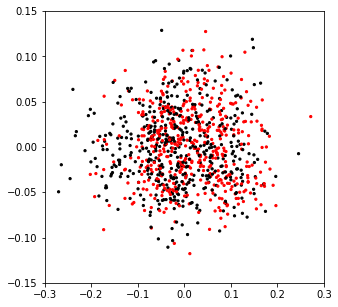

In [24]:
plot_embeddings(df_movies, movie_embeddings)

## RF accuracy with embeddings

In [27]:
X = df[['movieId','userId']]
y = df['rating']
X_emb = np.concatenate([movie_embeddings[X['movieId']-1],movie_embeddings[X['userId']-1]], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_emb, y, test_size=0.2)

rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True)
rf.fit(X_train, y_train)
print(f"OOB R^2 {rf.oob_score_:.3f}")
print(f"Train R^2 {rf.score(X_train, y_train):.3f}")
print(f"Valid R^2 {rf.score(X_test, y_test):.3f}")

OOB R^2 0.252
Train R^2 0.897
Valid R^2 0.269


*TODO mean center y*